In [ ]:
%matplotlib inline

# Deep Learning con Keras y TensorFlow


**Fuentes: [Daniel Moser]() [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

Para ayudar a comprender los fundamentos del deep learning, este cuaderno guiará a través de los pasos básicos de construcción de modelos para la clasificación de números escritos a mano (dataset MNIST) con precisiones que superan el 95%.

El primer modelo será un modelo con una red neuronal densa, y el segundo modelo será una red neuronal profunda que introduce los conceptos de redes convolucionales y pooling.

## Objetivo

Nuestro objetivo es construir y entrenar una red neuronal con miles de imágenes de números escritos a mano de forma que podamos hacer predicciones correctas de nuevas muestras escritas que se le presenten al modelo.

La base de datos MNIST que utilizaremos en este laboratorio contiene 60000 imágenes para aprendizaje, y 10000 imágenes de prueba. Usaremos el API de Python Keras con Tensorflow como backend.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1sQ7d_5L4hsLHNvCgcNbeZtnWzyo9Qdx_' />
<figcaption>MNIST Dataset</figcaption></center>
</figure>

## Módulos Python prerequisito

Primero, cargamos módulos que necesitaremos a lo largo del cuaderno:

In [ ]:
import numpy as np                   # Librería matemática avanzada
import matplotlib.pyplot as plt      # Librerías de plotting tipo MATLAB
import random                        # para generación de números aleatorios
import pandas as pd                  # Pandas

from keras.datasets import mnist     # MNIST dataset incluido en Keras
from keras.models import Sequential  # Tipo de modelo a utilizar

from keras.layers.core import Dense, Dropout, Activation # Tipos de capas que usaremos en nuestro modelo
from keras.utils import np_utils                         # Herramientas Numpy

Using TensorFlow backend.


## Carga de datos de entrenamiento

El dataset MNIST viene empaquetado con Keras por comodidad, y se pueden analizar algunas de sus características fácilmente con Python:

In [ ]:
# Los datos MNIST están repartidas entre 60000 imágenes de 28 x 28 píxeles y 10000 imágenes de 28 x 28 píxeles
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape, {y_train.shape}")
print(f"X_test shape, {X_test.shape}")
print(f"y_test shape, {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape, (60000,)
X_test shape, (10000, 28, 28)
y_test shape, (10000,)


Usamos matplotlib para mostrar algunas de las figuras del training set directamente en nuestro notebook:

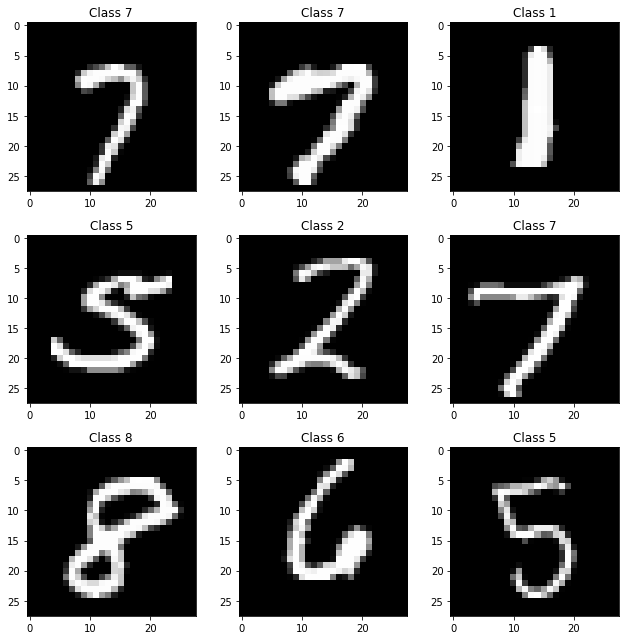

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Hacemos los gráficos un poco más grandes

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Vamos a examinar los números con más detalle, e imprimir un array que representa el último dígito de la matriz de 9 x 9 anterior con los valores que representa cada píxel:

In [ ]:
# Definimos una matriz para hacer una visualización de una matriz
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# la visualizamos        
matprint(X_train[num])

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    3    3   41  172  207  153   23    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0   77   99  115  180  180  202  206  254  237  168  149  239   80    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  189  254  249  229  229  205  121   64    0    0    9   55    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0   48  247   88    0    0    0    0    0    0    0    0    0    0    0  0  0 

Cada píxel es un entero de 8 bits de 0-255. 0 es negro, 255 es blanco, y los números intermedios son todos de gris. Esto es lo que llamamos un píxel monocanal, así que las imágenes son monocromo.

## Formateo de la capa de entrada

En vez de una matrix de 28 x 28, construimos nuestra red para aceptar una entrada de un vecto
Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Cada imagen tiene que ser redimensionada (aplanada) en un vector. También tendremos que normalizar las entradas para que esté en el rango $[0,1]$ en lugar del rango $[0-255]$. La normalización de las entradas en general se recomienda de tal forma que dimensiones adicionales tengan la misma escala.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1ToEoMOG8e1ujy3-ncvV3fxmvva_JZL_w' />
<figcaption>Aplanamiento</figcaption></center>
</figure>

In [ ]:
X_train = X_train.reshape(60000, 784) # Redimensionamos 60000 matrices de 28 x 28 en vectores de longitud 784
X_test = X_test.reshape(10000, 784)   # Redimensionamos 10000 matrices de 28 x 28 en vectores de longitud 784

X_train = X_train.astype('float32')   # Pasamos de enteros a números en punto flontate de 32 bits
X_test = X_test.astype('float32')

X_train /= 255                        # Normalizamos cada valor de cada pixel para cada vector de entrada
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


Ahora modificamos las clases (dígitos únicos) para que estén en formato *one-hot*:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

Si la salida final de nuestra red es muy próxima a una de las clases, entonces será probablemente de esa clase. Por ejemplo, si la salida final es:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
entonces lo más probable es que la imagen corresponda al número `1`.

In [ ]:
nb_classes = 10 # número de dígitos únicos

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Construccción de una fully connected network de 3 capas

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1A2p-57MRkK-fNtBgFDZyzTz4q8_h70V_' />
<figcaption>Red neuronal densamente conectada de 3 capas</figcaption></center>
</figure>

El modelo secuencial es un apilamiento lineal de capas y es muy común:

In [ ]:
model = Sequential()

## La primera hidden layer

La primera hidden layer está compuestas por 512 nodos (neuronas artificiales). Cada nodo recibe un elemento de un vector de entrada y le aplica pesos y un bias:

In [ ]:
model.add(Dense(512, input_shape=(784,))) #(784,) es la manera de representar un vector de longitud 784

Una activación es una función no lineal que se aplica a la salida de la capa que está por encima. La activación es lo que produce que una neurona artifical dispare o no en base a la entrada.

La función de activación Rectified Linear Unit (ReLU) pasa todas las entradas negativas a cero como entrada para la siguiente capa. Estas entradas "rectificadas" no provocan activación. Los valores positivos del nodo permanecen inalterados:


In [ ]:
model.add(Activation('relu'))

$$f(x) = max (0,x)$$

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1MEMUxhoC8RdTSwigAQ3EjVRfsQskxpTR' />
<figcaption>Rectified Linear Unit</figcaption></center>
</figure>

Dropout provoca la desactivación de un número aleatorio de salidas. Dropout ayuda a protejer el modelo contra la memorización o sobreajuste de los datos de entrenamiento: 

In [ ]:
model.add(Dropout(0.2))

## Adición de una segunda hidden layer

Una segunda hidden layer será idéntica a la primera que hemos añadido. Sin embargo, en vez de los 512 nodos que reciben vectores de longitud 784, ahora reciben 512 entradas de la salida de la primera capa:

In [ ]:
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## La capa final

La capa final, de 10 nodos, está completamente conectada a la capa previa de 512 nodos. La capa final de una fully connected network debería tener el mismo número de elementos que el número de clases deseadas (10 en este caso)

In [ ]:
model.add(Dense(10))

La activación **softmax** representa una distribución de probabilidad sobre $K$ posibles valores de salida. Sus valores son todos no negativos y su suma es 1:

In [ ]:
model.add(Activation('softmax'))

Mostramos un resumen del modelo:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

## Compilación del modelo

Keras se construye por encima de Theano y Tensorflow. Ambos paquetes permiten definir un *grafo computacional* en Python, que después se compila y ejecuta de manera eficiente en una CPU o una GPU sin la carga extra que supone el intérprete de Python.

Cuando compilamos un modelo, Keras pide una **función de pérdida** (*loss function*) y un **optimizador** específico (*optimizer*). La función de pérdida que utilizaremos aquí se llama *categorical cross-entropy*, y es una función que encaja bien cuando estamos comparando dos distribuciones de probabilidad.

Las predicciones que está realizando el modelo son distribuciones de probabilidad a lo largo de los 10 dígitos que tiene MNIST (por ejemplo, tenemos un 80% de certeza de que la imagen es un 3, un 10% de que es un 8, un 5% de que es un dos, etc.), y el objetivo es una distribución de probabilidad con un 100% para la categoría correcta, y 0 para todo lo demás. La entropía cruzada es una medida de cuán diferente es nuestra distribución de probabilidad de la objetivo. [Más detalles en Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

El optimizador ayuda a determinar cómo de rapido aprende el modelo usando **gradiente descendiente** (*gradient descent*). El ratio al que el gradiente desciente se llama **ratio o tasa de aprendizaje** (*learning rate*).

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1BppY18JhMRn4bdqFexvXjVymmhkSD9mW' />
<figcaption>Gradient Descent</figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1grGBrQODBVB_33QRnkeOOB1BD5pw6Cmo' />
<figcaption>Comparación de ratios de aprendizaje</figcaption></center>
</figure>

Entonces, según el gráfico ¿son mejores los ratios de aprendizaje pequeños? No, porque es importante para un optimizador no quedarse bloqueado en un mínimo local mientras se ignora el mínimo global de la función de pérdida.

A veces esto implica probar una tasa de apredizaje mayor para así poder saltar de un mínimo local y alcanzar el mínimo global.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1wvgqphK3JRpXL1OiPYlPjxg2hbBwtwUJ' />
<figcaption>Mínimo local y global</figcaption></center>
</figure>

Usamos el optimizador **adam** para realizar el entrenamiento:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamiento del modelo

El tamaño del lote determina cuántos datos por paso se utilizan para computar la función de pérdida, gradientes y *back propagation*. Tamaños grandes de lote permite a la red completar el entrenamiento más rápidamente. Sin embargo, hay otros factores admás de la velocidad de entrenamiento que debemos considerar.

Un tamaño de lote muy grande suaviza los mínimos locales de la función de pérdida, provocando que el optimizador se quede en ellos porque piensa que ha encontrado el mínimo global.

Un tamaño de lote muy pequeño crea una función de pérdida con mucho ruído, y puede que por eso el optimizador nunca llegue a encontrar el mínimo global.

La conclusión es que encontrar un buen tamaño de lote es una cuestión de prueba y error hasta dar con el ajuste que mejor resultados nos da.

Epoch 1/5
60000/60000 [==============================] - 2s 26us/step - loss: 0.0109 - accuracy: 0.9965
Epoch 2/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.0125 - accuracy: 0.9962
Epoch 3/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.0100 - accuracy: 0.9968
Epoch 4/5
60000/60000 [==============================] - 1s 25us/step - loss: 0.0122 - accuracy: 0.9962
Epoch 5/5
60000/60000 [==============================] - 2s 25us/step - loss: 0.0124 - accuracy: 0.9960


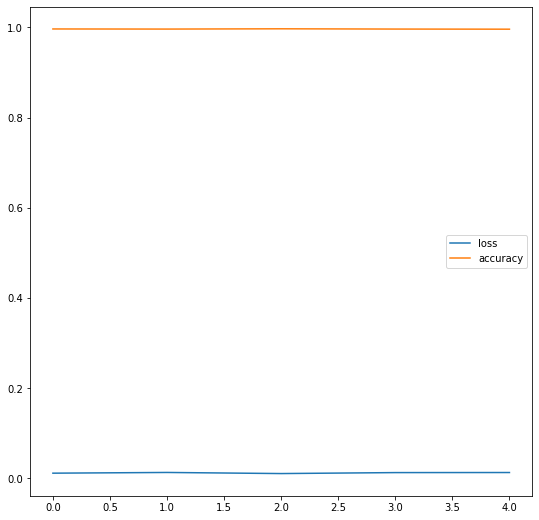

In [ ]:
#@title Set the batch size and train the model
batch_size = 128 #@param [128, 10000, 32] {type: 'raw'}
epochs = 5 #@param [5, 10, 50, 100] {type: 'raw'}
history_callback = model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=epochs,
          verbose=1)
pd.DataFrame(history_callback.history).plot()

Los dos número, en orden, representan el valor de la función de pérdida de la red sobre el conjunto de entrenamiento, así como la precisión general de la red sobre este conjunto.

¿Cómo se comporta el modelo cuando es expuesto a datos sobre los que no ha sido entrenado?

## Evaluación de la precisión del modelo

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 47us/step
Test score: 0.05937561286153195
Test accuracy: 0.984000027179718


### Inspeccionando la salida

Siempre es una buena idea inspeccionar la salida y asegurar que todo tiene la pinta que debería. Echaremos un vistazo a algunos ejemplos en los que el modelo acierta, y otros en los que falla.

La función predicted_classes devuelve la clase de más alta probabilidad de acuerdo al clasificar entrenado con los datos de entrenamiento.

In [ ]:
predicted_classes = model.predict_classes(X_test)


Comprobamos ahora qué elementos se predijeron correctamente y cuáles no:

In [ ]:
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

Los pintamos:

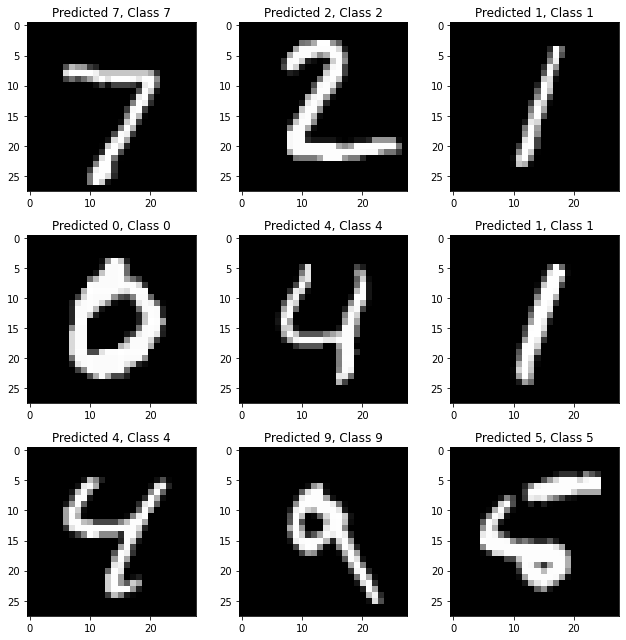

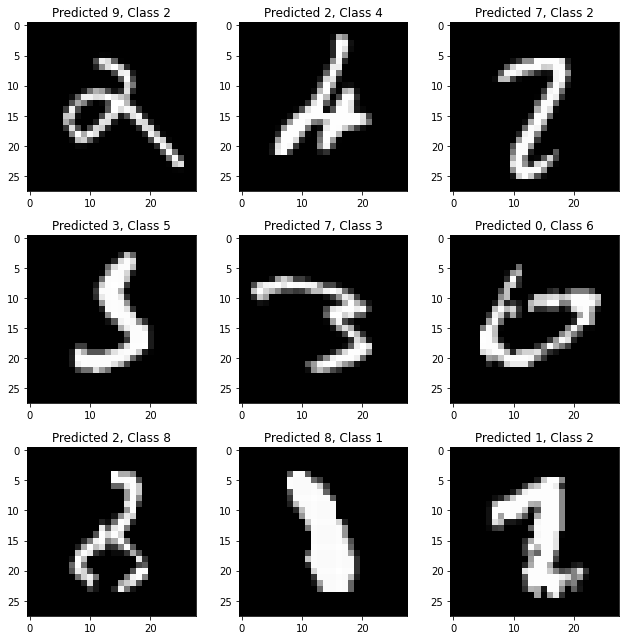

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

# Experimentando con el tamaño de lote

¿Cómo afecta al tiempo de entrenamiento y al tamaño de lote incrementar el tamaño de lote a 10000?

¿Qué ocurriría con un tamaño de lote de 32?

# Introducción al concepto de convolución

En los pasos previos, hemos construído una red que acepta la normalización de los valores de cada píxel de la imágen y que funciona exclusivamente con esos valores.

¿Qué tal si en vez de eso alimentamos a la red con diferentes características (curvatura, bordes, etc.) de cada una de las imágenes, y dejamos que la red aprenda aquellas que son importantes para poder realizar la clasificación de la imagen?

Esto es posible gracias a las convoluciones. Las convoluciones aplican **kernels** (filtros) que operan sobre cada imagen y generan lo que se llaman mapas de características.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1EYRqAdUMh3r1jdDuHKqJP86HOo1BG2HS' />
<figcaption>Convoluciones</figcaption></center>
</figure>

En el ejemplo de más arriba, la imágen es una matrix de 5 x 5 y el kernel que la está procesando es una matriz de 3 x 3. El kernel se aplica realizando la multiplicación elemento a elemento entre el kernel y el área correspondiente de la imagen, y con esto se genera una nueva característica (convolución). Cada kernel en una CNN aprende una característica diferente de la misma imagen.

Los kernels se utilizan con frecuencia en software de edición de Fotografía para aplicar difuminado, detección de bordes, resaltado de contraste, etc.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1J6aF6TAb4e2MPh1mQgdI1iXrihLDnXa5' />
<figcaption>Kernels</figcaption></center>
</figure>

Los kernels en redes neuronales profundas se usan de una manera similar, en el sentido de que resaltan una característica concreta. Combinados con una técnica llamada **max pooling**, los elementos no resaltados se descartan de cada mapa de características, dejando sólo aquellas características de interés y reduciendo así el número de parámetros que se están aprendiendo, lo que a su ven reduce el coste computacional del entrenamiento.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=14-UNQi3mx5-yf9NGTN1dmtTyn_LTZ6oI' />
<figcaption>Max pooling</figcaption></center>
</figure>

Támbién se pueden realizar convoluciones de las convoluciones, de forma que podemos apilar tantas convoluciones como queramos, siempre que queden suficiences pixels para acomodar al kernel.

Lo que puede ocurrir es que lo que vaya apareciendo aguas abajo en las convoluciones no aparezca reconocible a un ser humando como consecuencia de la aplicación de múltiples filtros uno detrás de otro.

## Construción de una red convolucional profunda

Imporamos algunas herramientas y módulos adicionales:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

Recargamos los datos de MNIST:

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


De nuevo, aplicamos ciertas transformaciones dimensionales y de tipos a los datos. En esta ocasión, no aplanamos las imágenes porque antes de aplicar capas densas queremos aplicar convoluciones y necesitamos la información bidimensional.

Añadimos una dimensión extra para representar nuestro único canal:

In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

Cambiamos los enteros a número de punto flotante de 32 bits:

In [ ]:
X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

Normalizamos el valor de cada pixel para muestra de la entrada:

In [ ]:
X_train /= 255
X_test /= 255

print(f"Training matrix shape: {X_train.shape}")
print(f"Testing matrix shape: {X_test.shape}")

Training matrix shape: (60000, 28, 28, 1)
Testing matrix shape: (10000, 28, 28, 1)


Hacemos un formateado *one-hot* de las clases:

In [ ]:
nb_classes = 10 # número de dígitos

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Configuramos nuestro modelo con un API secuencia, tal y como hicimos antes:

In [ ]:
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 kernels 3x3 diferentes -- 32 feature maps
model.add(BatchNormalization(axis=-1))               # Normalizamos los feature maps antes de la activación
convLayer01 = Activation('relu')                     # Activacion
model.add(convLayer01)

# Segunda capa convolucional
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Tercera capa convolucional
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)       

Utilizamos el mismo optimizador, **adam**:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Utilizamos las técnicas de aumentado de datos que hemos mencionado para prevenir el sobreajuste haciendo que se produzcan cambios aleatorios en varios aspectos de la imagen. Keras tiene funcionalidad incluida de manera automática para hacerlo a través del módulo `ImageDataGenerator`:

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

Ahora podemos alimentar los datos alimentados en lote. Además de las consideraciones sobre la función de pérdida que hicimos anteriormente, este método ahorra una cantidad considerable de memoria porque lo que estamos haciendo en realidad es cargar los datos en la red en lotes antes de procesar cada lote.

Esto contrasta con la aproximación anterior, donde todos los datos se almacenaban en memoria, y luego eran procesados en lotes.

In [ ]:
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

Entrenamos nuestro modelo, alimentándolo con el cargador de lotes. El número de pasos por época debería ser siempre el tamaño total del conjunto de entrenamiento dividido por el tamaño del lote:

In [ ]:
# Ahorros de memoria considerables, importante para redes más grandes y profundas

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5
468/468 [==============================] - 40s 86ms/step - loss: 0.1337 - accuracy: 0.9588 - val_loss: 0.0246 - val_accuracy: 0.9845
Epoch 2/5
468/468 [==============================] - 34s 73ms/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.0132 - val_accuracy: 0.9926
Epoch 3/5
468/468 [==============================] - 34s 73ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0139 - val_accuracy: 0.9924
Epoch 4/5
468/468 [==============================] - 33s 71ms/step - loss: 0.0341 - accuracy: 0.9891 - val_loss: 0.1127 - val_accuracy: 0.9859
Epoch 5/5
468/468 [==============================] - 34s 73ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0427 - val_accuracy: 0.9876


In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 212us/step
Test score: 0.03782507136474014
Test accuracy: 0.9876999855041504


## Resultados

Los resultados son bastante buenos. Sería además útil poder visualizar las convoluciones de forma que veamos lo que el modelo ve.

In [ ]:
from keras import backend as K

# Elegimos una de las imágenes del conjunto de test especificando su índice
img = X_test[3]
# Keras requiere que la imagen sea 4D, así que añadimos una dimensión extra
img = np.expand_dims(img, axis=0)

# No es importante entender la siguiente función, simplemente dibuja el contenido
# de una capa convolucional

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
    
    _convout1_f = K.function(inputs, [layer.output])
    
    def convout1_f(X):
        # El [0] es para deshabilitar el flag de entrenamiento
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))
    
    # Visualización de cada filtro de la capa
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')


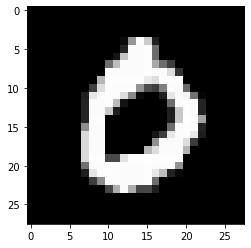

In [ ]:
plt.figure()
plt.imshow(X_test[3].reshape(28,28), cmap='gray', interpolation='none')

Visualizamos el primer conjunto de feature maps

Shape of conv: (26, 26, 32)


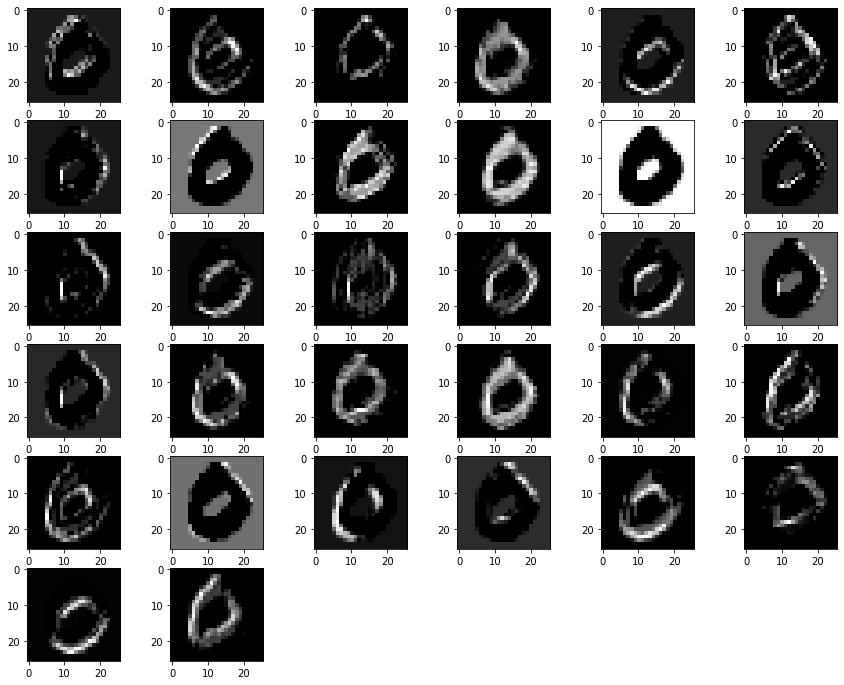

In [ ]:
visualize(convLayer01)

Visualizamos el segundo ocnjunto de feature maps

Shape of conv: (12, 12, 32)


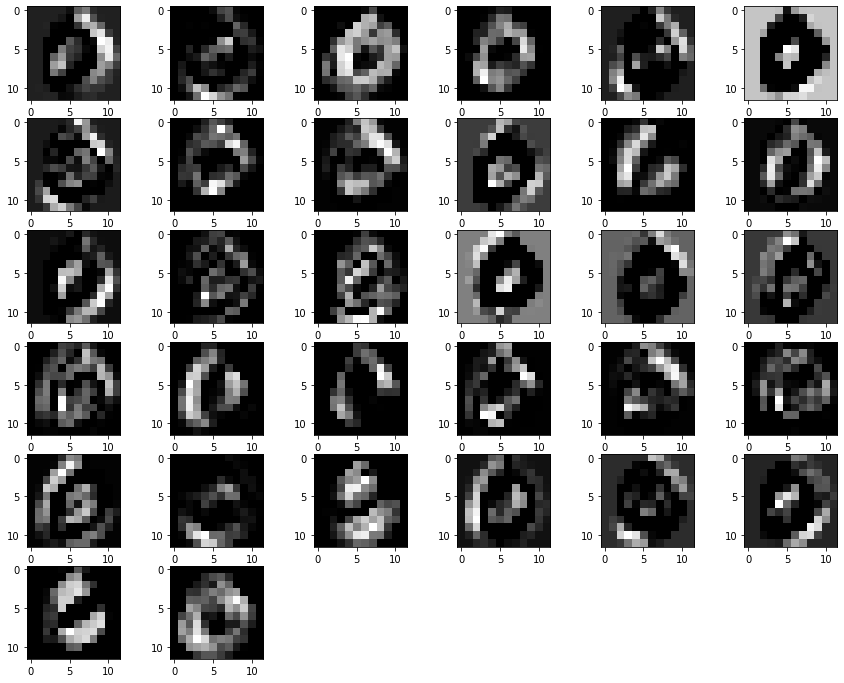

In [ ]:
visualize(convLayer02)

Visualizamos el tercer conjunto de feature maps:

Shape of conv: (10, 10, 64)


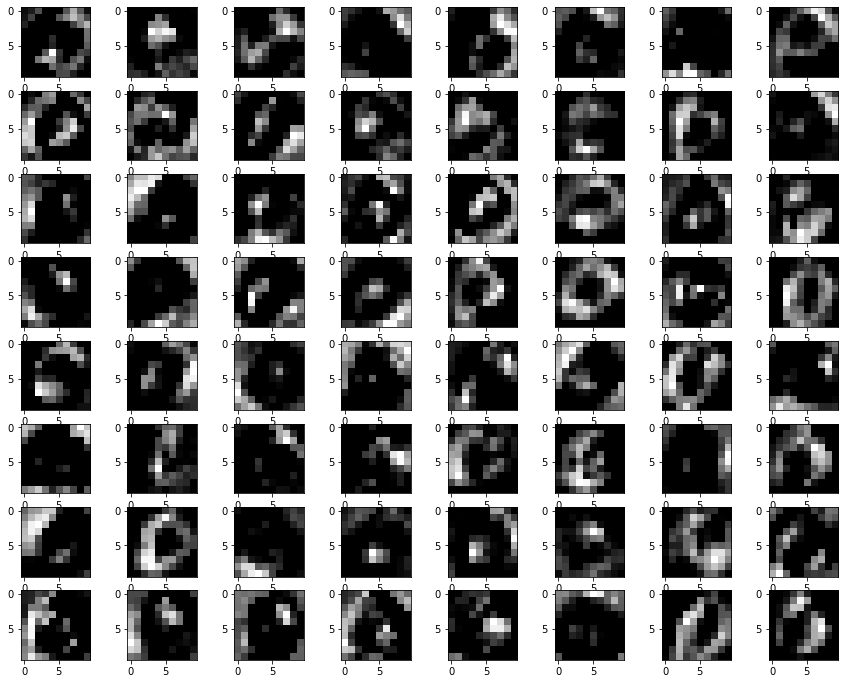

In [ ]:
visualize(convLayer03)

Visualizamos el cuarto conjunto de feature maps:

Shape of conv: (4, 4, 64)


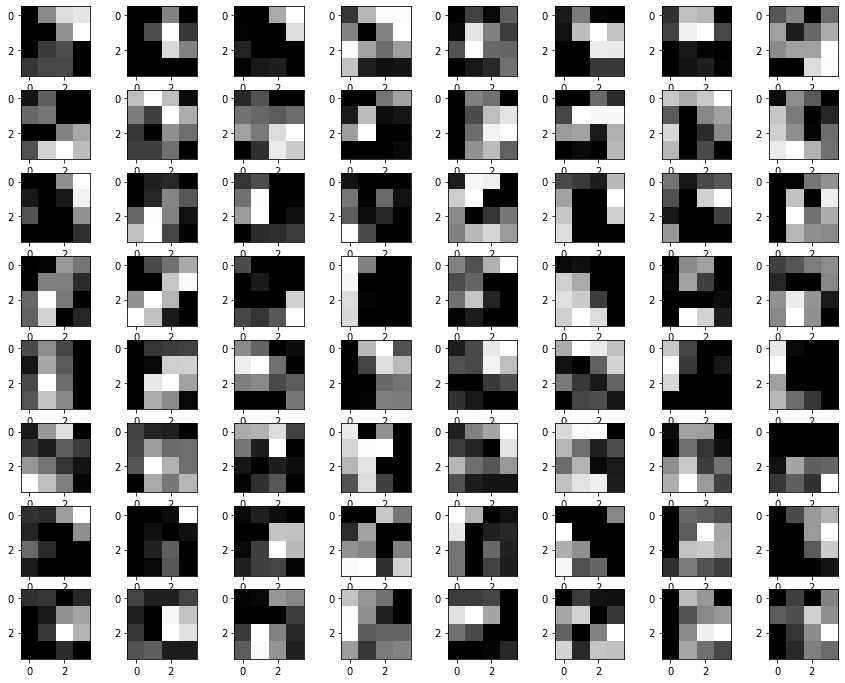

In [ ]:
visualize(convLayer04)

Para una visualización tridimensional de una red muy similar, visitar http://scs.ryerson.ca/~aharley/vis/conv/